In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avocado-prices/avocado.csv


# <아보카도 가격 예측>

본 과제의 목표는 아보카도 가격의 변화를 관찰하고 시계열 분석을 통해 예측하고자 함에 있다.

분석의 순서는 다음과 같다.
* Step 1. 데이터 가져오기
* Step 2. 데이터 전처리
* Step 3. 데이터 시각화
* Step 4. 시계열 분석
* Step 5. 모델 평가


# Step 1. 데이터 가져오기

In [41]:
# 데이터 분석 라이브러리
import numpy as np
import pandas as pd 
import datetime as dt

# 시각화 라이브러리
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 시계열 분석 라이브러리
from fbprophet import Prophet

# 파이프라인 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [42]:
def show_files():
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
        
show_files()

/kaggle/input/avocado-prices/avocado.csv


In [43]:
data = pd.read_csv('/kaggle/input/avocado-prices/avocado.csv')

#상위 5개 컬럼
data.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


# Step 2. 데이터 전처리

본 과제에서 이용된 데이터는 Hass Avocado Board website에서 2018년 5월에 공개한 Avocado Prices로, 미국 소매 상점에서 판매된 아보카도의 주간 수량과 가격을 포함하고 있다 (https://www.kaggle.com/neuromusic/avocado-prices).
각각의 열은 다음과 같은 데이터를 포함하고 있다.

* Date: 판매된 날짜 
* AveragePrice: 아보카도 한개의 평균 가격
* Total Volume: 판매된 아보카도의 전체 수량
* 4046: 판매된 PLU 4046 아보카도의 갯수 (작은 Hass 아보카도)
* 4225: 판매된 PLU 4225 아보카도의 갯수 (큰 Hass 아보카도)
* 4770: 판매된 PLU 4770 아보카도의 갯수 (매우 큰 Hass 아보카도)
* type: 일반(conventional) 또는 유기농(organic)
* year: 년도
* Region: 판매된 도시

Total Bags, Small Bags, Large Bags, XLarge Bags는 Bag으로 포장되어 팔린 갯수와 관련한 데이터로, 아보카도의 가격과는 연관성이 없다고 판단되어 본 과제의 분석에서 제외한다.

In [44]:
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [45]:
df = data[:]

#해당 분석에서 가격 예측시 필요 없어서 삭제
for col in ["Small Bags", "Large Bags", "XLarge Bags"]:
    del df[col]
    
df.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,conventional,2015,Albany


In [46]:
names = ["Unnamed: 0","Date", "AveragePrice", "Total Volume", "small", "large", "xlarge", "Total Bags", "type", "year", "region"]
df = df.rename(columns=dict(zip(df.columns, names)))


df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,small,large,xlarge,Total Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,conventional,2015,Albany


In [47]:
# 데이터 형식 살펴보기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   small         18249 non-null  float64
 5   large         18249 non-null  float64
 6   xlarge        18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   type          18249 non-null  object 
 9   year          18249 non-null  int64  
 10  region        18249 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 1.5+ MB


In [48]:
# float 타입 데이터 살펴보기 
df.describe()

,Unnamed: 0,AveragePrice,Total Volume,small,large,xlarge,Total Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,2018.000000


In [49]:
# object 타입 데이터 살펴보기
df["type"].value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

In [50]:
df["region"].value_counts()

GrandRapids            338
Columbus               338
BuffaloRochester       338
Jacksonville           338
HartfordSpringfield    338
RaleighGreensboro      338
West                   338
NewYork                338
Louisville             338
Charlotte              338
CincinnatiDayton       338
NewOrleansMobile       338
Tampa                  338
SouthCarolina          338
Boston                 338
Indianapolis           338
Detroit                338
Seattle                338
SanDiego               338
LasVegas               338
Pittsburgh             338
MiamiFtLauderdale      338
Syracuse               338
DallasFtWorth          338
RichmondNorfolk        338
NorthernNewEngland     338
Houston                338
Portland               338
California             338
BaltimoreWashington    338
Chicago                338
Atlanta                338
Plains                 338
TotalUS                338
Philadelphia           338
Roanoke                338
Northeast              338
B

In [51]:
# date 열의 데이터가 datatime 타입이 아니기 때문에, 날짜를 년, 월, 일로 나누기
dates = [dt.datetime.strptime(ts, "%Y-%m-%d") for ts in df['Date']]
dates.sort()
sorted_dates = [dt.datetime.strftime(ts, "%Y-%m-%d") for ts in dates]
df['Date'] = pd.DataFrame({'date':sorted_dates})
df['year'], df['month'], df['day'] = df['Date'].str.split('-').str
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


,Unnamed: 0,Date,AveragePrice,Total Volume,small,large,xlarge,Total Bags,type,year,region,month,day
0,0,2015-01-04,1.33,64236.62,1036.74,54454.85,48.16,8696.87,conventional,2015,Albany,01,04
1,1,2015-01-04,1.35,54876.98,674.28,44638.81,58.33,9505.56,conventional,2015,Albany,01,04
2,2,2015-01-04,0.93,118220.22,794.70,109149.67,130.50,8145.35,conventional,2015,Albany,01,04
3,3,2015-01-04,1.08,78992.15,1132.00,71976.41,72.58,5811.16,conventional,2015,Albany,01,04
4,4,2015-01-04,1.28,51039.60,941.48,43838.39,75.78,6183.95,conventional,2015,Albany,01,04


# Step 3. 데이터 시각화

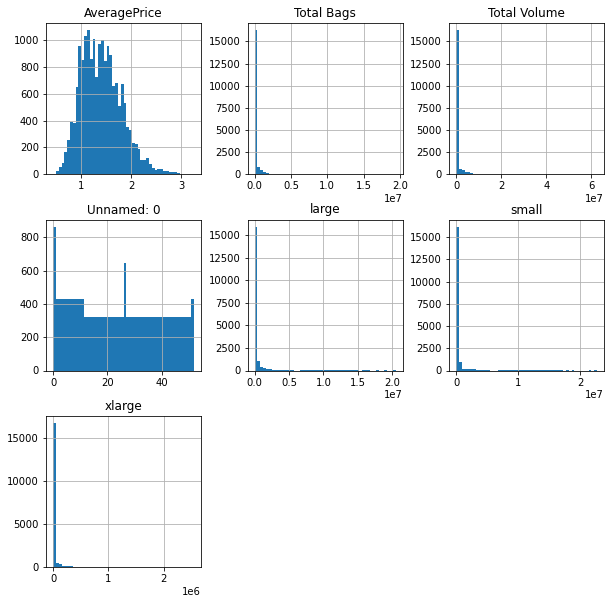

In [52]:
# 모든 float 타입 데이터 시각화하여 살펴보기
df.hist(bins=50, figsize=(10, 10))
plt.show()

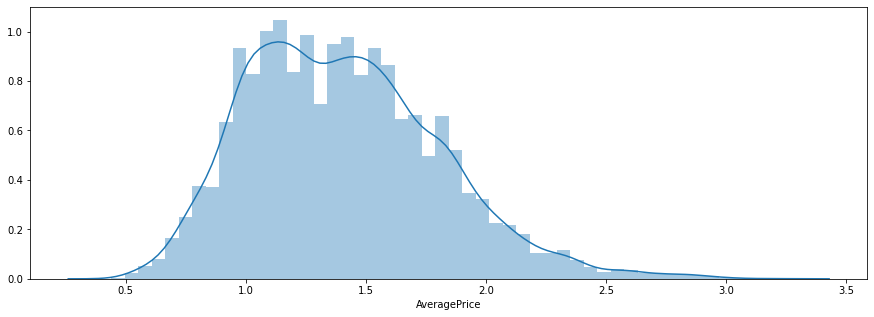

In [53]:
# 평균 가격 데이터만 시각화
plt.figure(figsize=(15,5))
ax = sns.distplot(df["AveragePrice"])

아보카도의 평균 가격이 대체적으로 1~1.5달러임을 알 수 있다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17e6804550>,
      dtype=object)

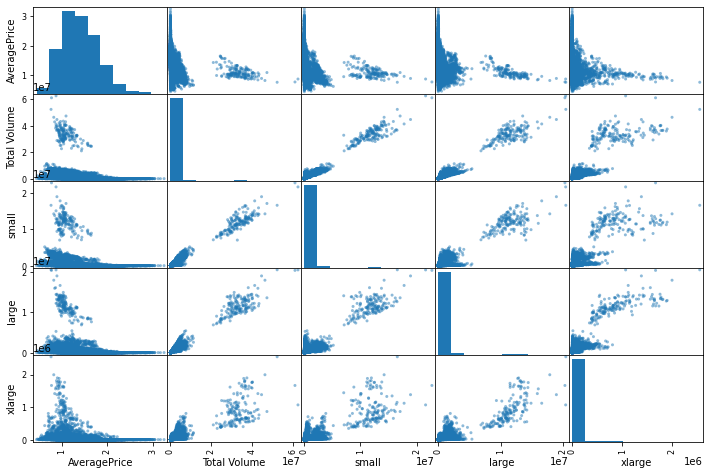

In [54]:
# 특성 사이의 상관관계 확인
from pandas.plotting import scatter_matrix
attributes = ["AveragePrice", "Total Volume", "small", "large", "xlarge"]
scatter_matrix(df[attributes], figsize=(12, 8))

평균 가격이 1달러 언저리일 때, 모든 크기의 아보카도가 많이 팔리는 경향에 있다.

total volume, small, large, xlarge는 수량과 관련된 특성으로 1차 함수의 관계를 갖는다.

Text(0.5, 1.0, 'Average Price')

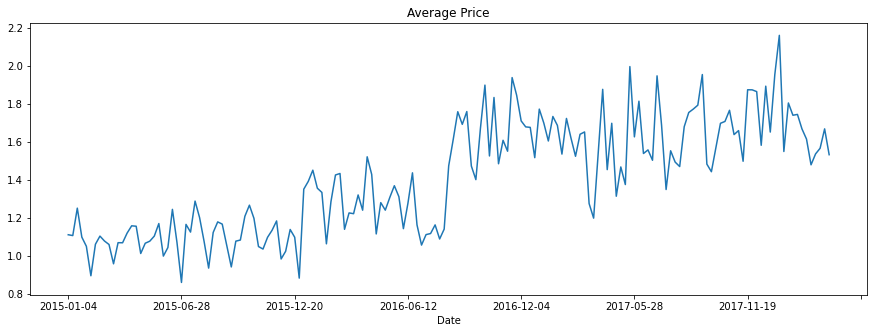

In [55]:
# 날짜에 따른 가격 분포
price_date=df.groupby('Date').mean()
plt.figure(figsize=(15,5))
price_date['AveragePrice'].plot(x=df.Date)
plt.title('Average Price')

아보카도 가격은 전체적으로 꾸준히 상승하는 경향을 보이나, 한달을 기준으로 증가했다 감소하는 반복적 추세를 보인다

Text(0.5, 1.0, 'Average Price by Year')

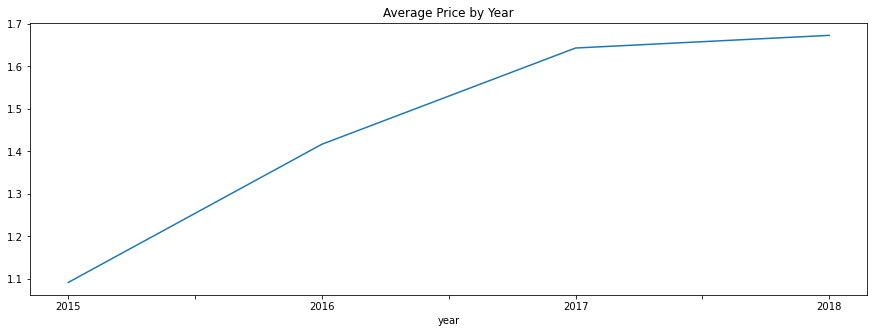

In [56]:
# 년도에 따른 가격 분포
price_year=df.groupby('year').mean()
fig, ax = plt.subplots(figsize=(15,5))
price_year['AveragePrice'].plot(x=df.year)
plt.title('Average Price by Year')

연도에 따른 아보카도 가격의 변화를 통해 2015년부터 아보카도 가격은 꾸준히 상승했으며 그 상승폭은 작아지고 있음을 알 수 있다.

Text(0.5, 1.0, 'Average Price by Month')

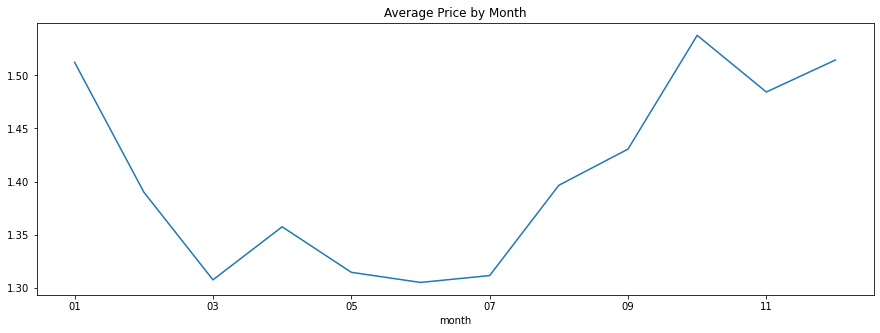

In [57]:
# 월별 가격 분포
price_month=df.groupby('month').mean()
fig, ax = plt.subplots(figsize=(15,5))
price_month['AveragePrice'].plot(x=df.month)
plt.title('Average Price by Month')

월별 아보카도 가격의 변화를 통해 7월부터 아보카도 가격이 상승하다가 1월이 되면 하락하는 추세를 확인할 수 있다.

Text(0.5, 1.0, 'Average Price by Day')

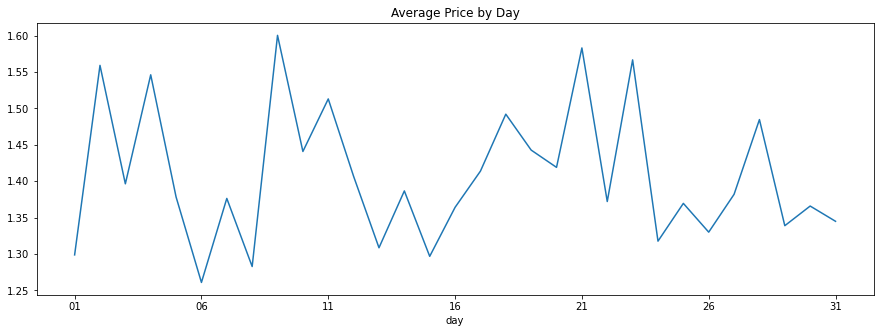

In [58]:
# 일별 가격 분포
price_day=df.groupby('day').mean()
fig, ax = plt.subplots(figsize=(15,5))
price_day['AveragePrice'].plot(x=df.day)
plt.title('Average Price by Day')

일별 아보카도 가격의 변화를 통해 한달 중 6일에 아보카도 가격이 최저이며, 9일에 최대인 것을 확인할 수 있다.

Text(0.5, 1.0, 'Average Price by Year in Each Region')

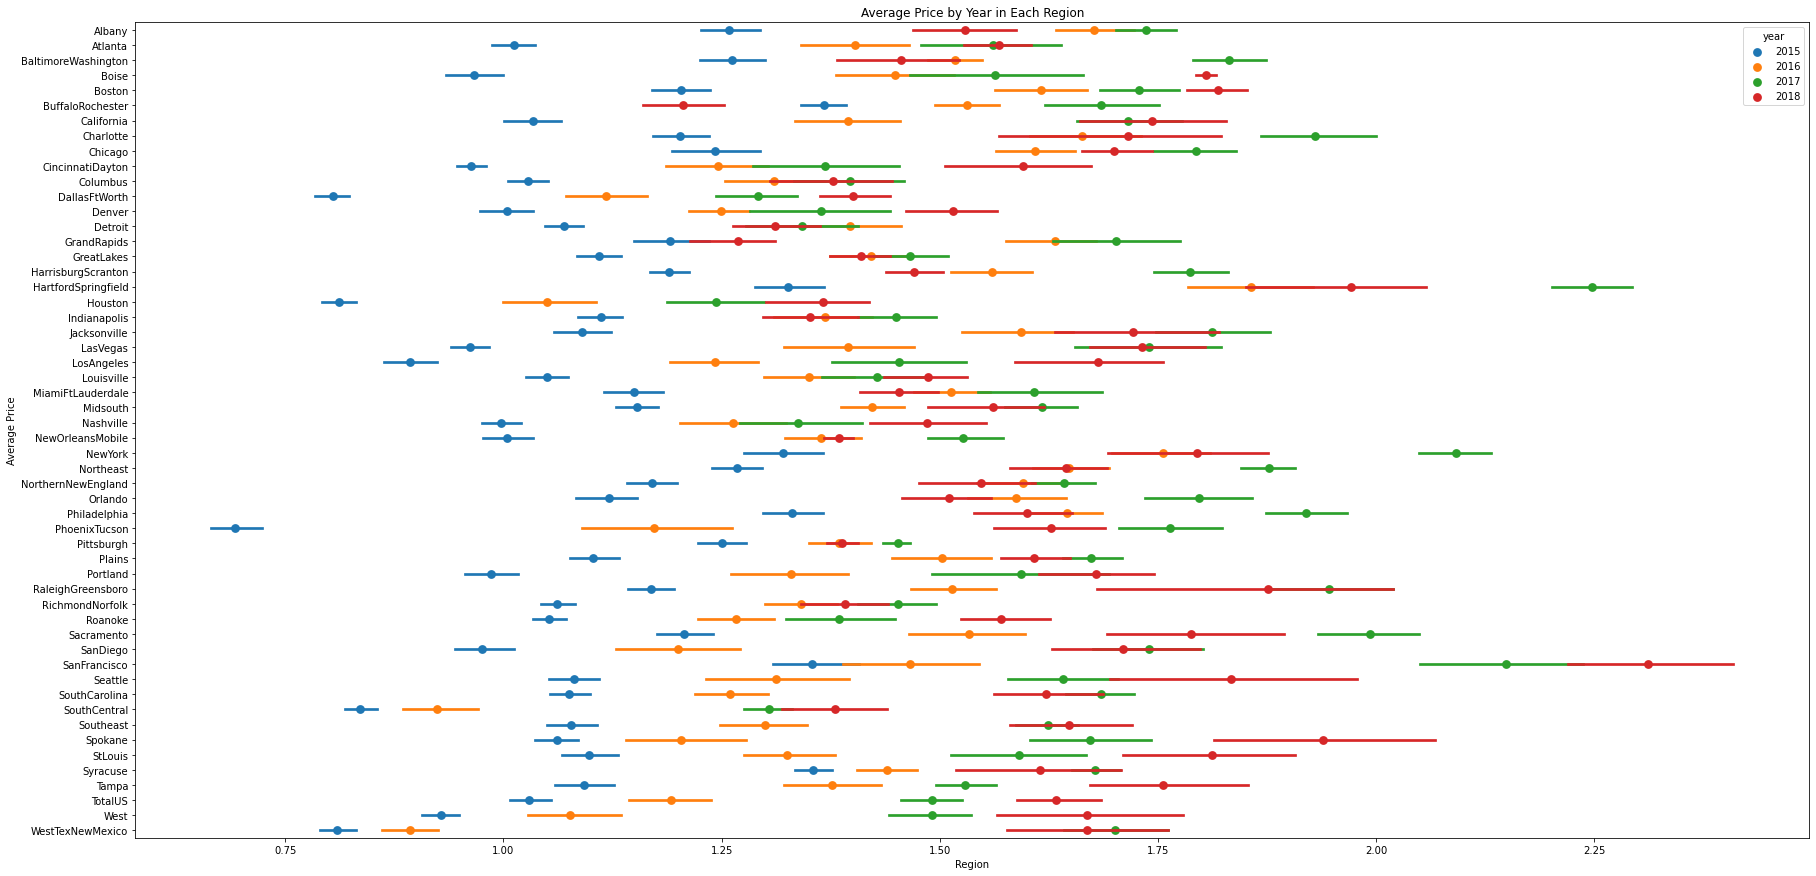

In [59]:
# 지방에 따른 연도별 아보카도 평균 가격
plt.figure(figsize=(30,15))
sns.pointplot(x='AveragePrice', y='region', data=df, hue='year',join=False)
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title("Average Price by Year in Each Region")

지방에 따라 년도별 아보카도의 평균 가격이 상이하나, 모두 꾸준히 증가하는 추세를 보인다

모든 지방이 2015년에 아보카도가 가장 저렴했지만, 최고 가격인 연도는 지방에 따라 다르다. 하지만 본 과제에 사용된 데이터가 2018년 초기까지만 관찰된 데이터이기 때문에 발생한 오류일 수 있다.

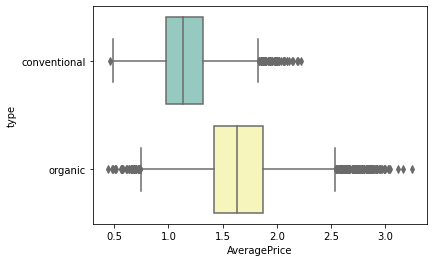

In [60]:
sns.boxplot(y="type", x = "AveragePrice", data=df, palette = 'Set3')

일반(conventional) 또는 유기농(organic)
최소 최대 이상치를 나타내며 일반 아보카드는 1.0달러부터 1.4정도  유기농 아보카드는 1.4부터 1.8의 범위를 가진다

유기농 아보카도가 전통식 아보카도보다 비싸

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


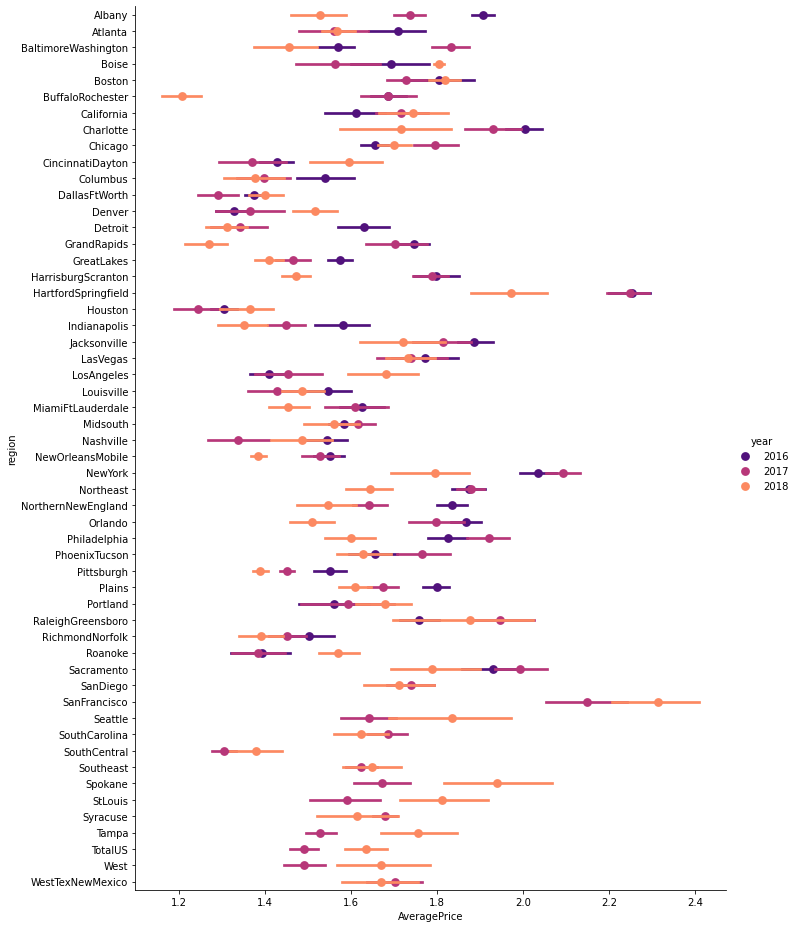

In [61]:
#일반
mask = df['type']=='organic'
g = sns.factorplot('AveragePrice', 'region', data=df[mask], hue='year',size=13,aspect=0.8,palette='magma',join=False)

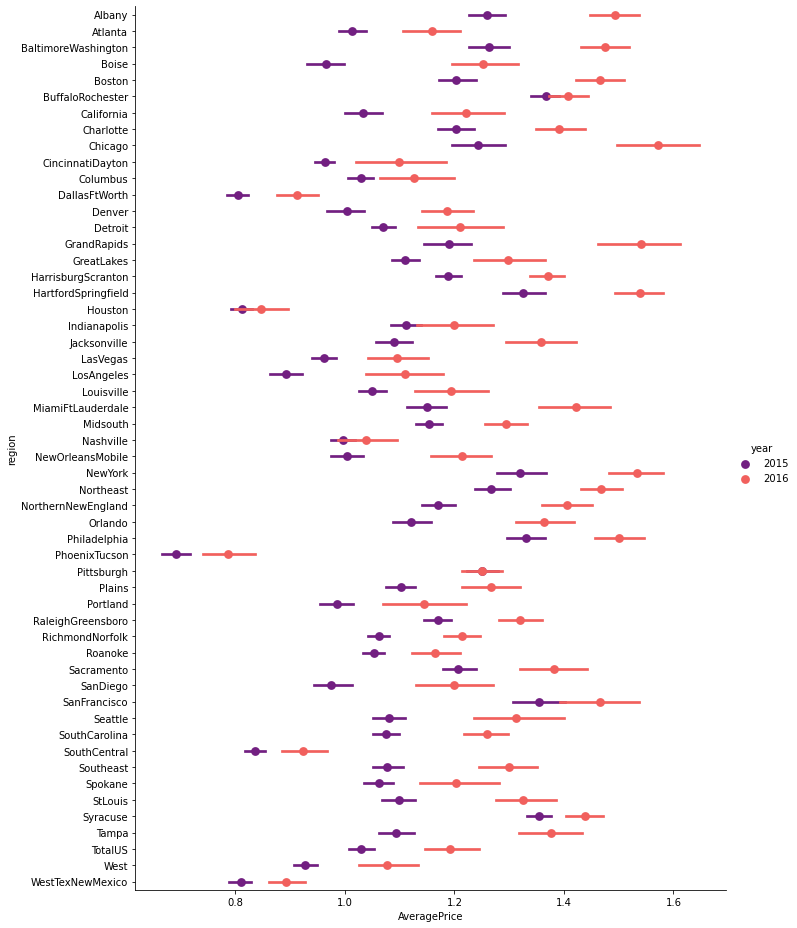

In [62]:
#유기농
mask = df['type']=='conventional'
g = sns.factorplot('AveragePrice', 'region', data=df[mask], hue='year',size=13,aspect=0.8,palette='magma',join=False)

# Step 4. 시계열 분석

In [63]:
# 시계열 분석을 위한 데이터 프레임 만들기
df_avocado =df.loc[:, ["Date","AveragePrice"]]
df_avocado['Date'] = pd.DatetimeIndex(df_avocado['Date'])

# 시계열 분석을 위한 열 이름 바꾸기
df_avocado = df_avocado.rename(columns={'Date': 'ds', 'AveragePrice': 'y'})
df_avocado.head()

,ds,y
0,2015-01-04,1.33
1,2015-01-04,1.35
2,2015-01-04,0.93
3,2015-01-04,1.08
4,2015-01-04,1.28


In [64]:
df_avocado.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [65]:
# 훈련 데이터와 테스트 데이터 나누기
n_data = 1296
train_avocado = df_avocado[:-n_data]
test_avocado = df_avocado[-n_data:]
print(len(train_avocado), "train +", len(test_avocado), "test")

16953 train + 1296 test


In [66]:
from sklearn.model_selection import train_test_split # 데이터 분할 모듈

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [67]:
# 학습용, 테스트용으로 데이터 나누기
train, test = train_test_split(df_avocado, train_size = 0.8)

train_X = train[['ds']] # 학습 입력
train_y = train.y # 학습 정답

test_X = test[['ds']] # 테스트 입력
test_y = test.y # 테스트 정답

In [76]:
LR = LinearRegression()
# LR.fit(train_X, train_y)
LR.fit(X.values.reshape(-1,1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

TypeError: invalid type promotion

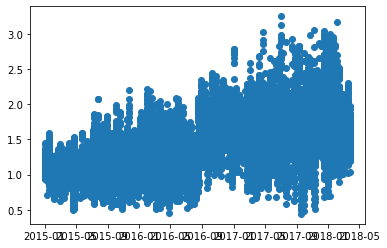

In [99]:
LR = LinearRegression()
LR.fit(train_X, train_y)
# LR.fit(X.values.reshape(-1,1), y)

X = df_avocado["ds"]
y = df_avocado["y"]
plt.plot(X, y, 'o')
plt.plot(X,LR.predict(X.values.reshape(-1,1)))
plt.show()

Score: 0.503


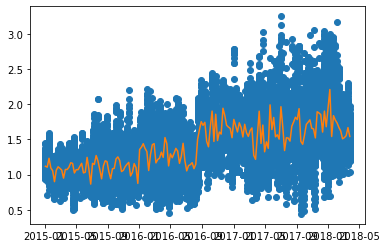

In [97]:
RFR = RandomForestRegressor(n_estimators=28,random_state=0)
RFR.fit(train_X, train_y)

score = RFR.score(test_X, test_y)
print('Score:', format(score,'.3f'))

X = df_avocado["ds"]
y = df_avocado["y"]
plt.plot(X, y, 'o')
plt.plot(X,RFR.predict(X.values.reshape(-1,1)))
plt.show()

Score: 0.503


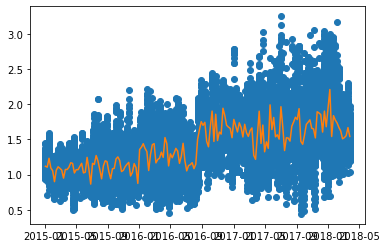

In [100]:
DTR = DecisionTreeRegressor(random_state = 0) 
DTR.fit(train_X, train_y) #fit은 DTR에 이 데이터를 몸에 맞게 학습 시켜줌

#테스트 계산하기, test_score
score = DTR.score(test_X, test_y) #스스로 자기가 문제와 정답 체크
print('Score:', format(score, '.3f')) 
# score의 의미: 정확하게 예측하면 1, 평균으로 예측하면 0, 더 못 예측하면 음수
#score 리턴된 값


X = df_avocado["ds"]
y = df_avocado["y"]
plt.plot(X, y, 'o')
plt.plot(X,RFR.predict(X.values.reshape(-1,1)))
plt.show()

In [ ]:
train, test = train_test_split(df_avocado, train_size = 0.8)
regress=LinearRegression()
regress.fit(train_X,train_y)

score = regress.score(test_X, test_y) #테스트 문제, 테스트 정답 #스스로 자기가 문제와 정답 체크
print('Score:', format(score, '.3f'))
# pred_y=regress.predict(test_X)
# from sklearn.metrics import r2_score
# from sklearn.model_selection import cross_val_score

# print(r2_score(test_y,pred_y))

In [ ]:
test_avocado.head()

In [92]:
# 계절성 고려
train_avocado['cap'] = train_avocado.y.max()
train_avocado['floor'] = train_avocado.y.min()

time_model = Prophet(growth='logistic', interval_width=0.95)
time_model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
time_model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)
time_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

time_model.fit(train_avocado)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
# 미래 가격 예측
future_dates = time_model.make_future_dataframe(periods=12, freq='w')
future_dates['cap'] = train_avocado.y.max()
future_dates['floor'] = train_avocado.y.min()

forecast = time_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# ds: the datestamp of the forecasted value
# yhat: the forecasted value of metric
# yhat_lower: the lower bound of forecasts
# yhat_upper: the upper bound of forecasts

,ds,yhat,yhat_lower,yhat_upper
16960,2018-02-25,1.936575,1.376434,2.495486
16961,2018-03-04,1.871003,1.256973,2.444780
16962,2018-03-11,1.760727,1.219345,2.353334
16963,2018-03-18,1.582004,1.068390,2.143691
16964,2018-03-25,1.501410,0.925482,2.058667


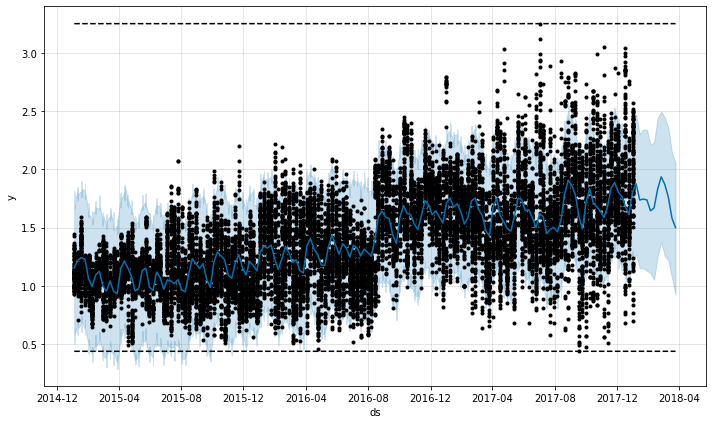

In [94]:
fig = time_model.plot(forecast)

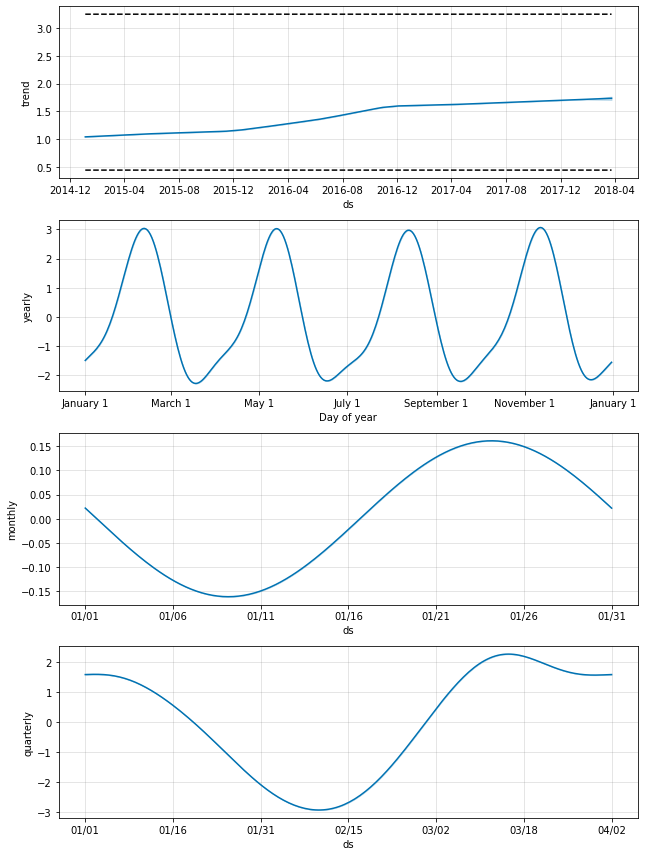

In [95]:
fig = time_model.plot_components(forecast)

Red = Predicted Values, Blue = Base Values


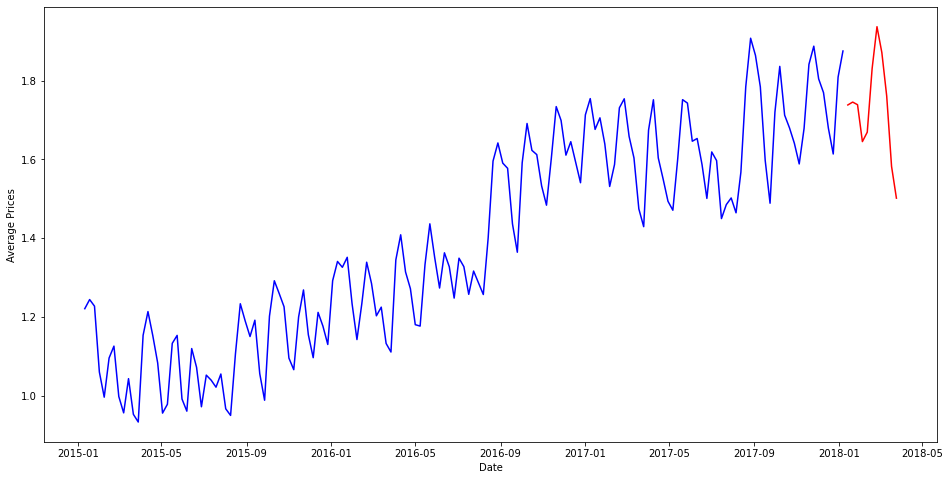

In [96]:
# 예측된 그래프 살펴보기
forecast_copy = forecast['ds']
forecast_copy2 = forecast['yhat']
forecast_copy = pd.concat([forecast_copy,forecast_copy2], axis=1)

mask = (forecast_copy['ds'] > "2018-01-07") & (forecast_copy['ds'] <= "2018-03-25")
forecasted_values = forecast_copy.loc[mask]
mask = (forecast_copy['ds'] > "2015-01-04") & (forecast_copy['ds'] <= "2018-01-07")
forecast_copy = forecast_copy.loc[mask]

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(forecast_copy.set_index('ds'), color='b')
ax1.plot(forecasted_values.set_index('ds'), color='r')
ax1.set_ylabel('Average Prices')
ax1.set_xlabel('Date')
print("Red = Predicted Values, Blue = Base Values")

# Step 5. 모델 평가

In [101]:
test_avocado = pd.concat([test_avocado.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')

columns = ['y', 'yhat', 'yhat_lower', 'yhat_upper']
test_avocado = test_avocado[columns]

test_avocado.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-01-07,1.88,1.874891,1.273218,2.470423
2018-01-07,2.06,1.874891,1.273218,2.470423
2018-01-07,1.59,1.874891,1.273218,2.470423
2018-01-07,1.72,1.874891,1.273218,2.470423
2018-01-07,1.42,1.874891,1.273218,2.470423


Measuring forecast accuracy (https://pdfs.semanticscholar.org/af71/3d815a7caba8dff7248ecea05a5956b2a487.pdf)
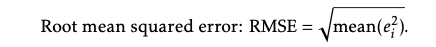


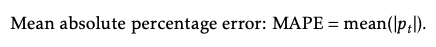 

In [102]:
# 정확성 측정
test_avocado['e'] = test_avocado.y - test_avocado.yhat
rmse = np.sqrt(np.mean(test_avocado.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test_avocado.e/test_avocado.y)), 0)
print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 0.4
MAPE = 20.0 %


에러값의 평균은 0.4달러이며 퍼센티지로는 20%이다.